#### Dataset/DataLoader

In [6]:
from myo_sam.dataset import MyoData
from torch.utils.data import DataLoader

In [7]:
dataset = MyoData("/Users/giorginozadze/Desktop/instance_sam/data/")
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [17]:
image, masks = next(iter(dataloader))

In [18]:
# (B, C, H, W) image transformed
# (B, N, H, W) masks transformed
image.shape, masks.shape

(torch.Size([1, 3, 1024, 1024]), torch.Size([1, 70, 1024, 1024]))

(-0.5, 1023.5, 1023.5, -0.5)

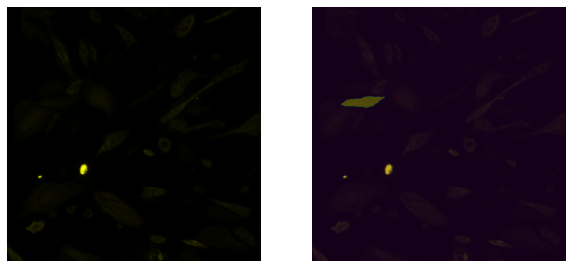

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[0].permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image[0].permute(1, 2, 0))
plt.imshow(masks[0][16], alpha=0.3)
plt.axis('off')

#### Training Algorithm

In [82]:
import torch
from typing import Union
from myo_sam.training import (
    sample_initial_points,
    sample_point_from_error_region
)
# modify gt_mask from above for testing purposes
modified: torch.Tensor = masks[0][16].clone()
modified[350:450, 0:200] = 0
modified[350:450, 200:250] = 1

def predict_masks_fake(
    img_embeddings: torch.Tensor,
    point_prompt: Union[tuple[int, int], None]=None,
    mask_logits: Union[torch.Tensor, None]=None,
):
    B = len(img_embeddings)
    logits = torch.rand(B, 1, 1024, 1024)
    # (B, 1, 1024, 1024)
    masks = torch.repeat_interleave(
        modified.unsqueeze(0).unsqueeze(0), B, axis=0
    )
    return logits, masks

def run_training_algo_batch(
    img_embeddings: torch.Tensor, # (B, 256, 64, 64)
    gt_masks: torch.Tensor, # (B, 1, 1024, 1024)
    its: int=8
):
    point_test = []
    B, _, _, _ = gt_masks.shape
    # Sample initial points ([B, 1, 2], [B, 1])
    initial_points = sample_initial_points(gt_masks)
    point_test.append(initial_points)
    # Predict mask (B, 1, 1024, 1024)
    logits, pred_masks_torch = predict_masks_fake(
        img_embeddings, initial_points
    )

    # Only mask step
    only_mask_step = torch.randint(1, its, (1, ))

    # Error Region
    for i in range(its+2):
        # Sample a point prompt from the error region (B, 1, 2), (B, 1)
        error_region_points = sample_point_from_error_region(
            gt_masks,
            pred_masks_torch
        )
        point_test.append(error_region_points)
        # Predict mask
        logits, pred_masks_torch = predict_masks_fake(
            img_embeddings,
            error_region_points,
            mask_logits=(
                logits if (i != only_mask_step or i != its + 1) else None
            )
        )
    return point_test

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color='green',
        marker='*',
        s=marker_size,
        edgecolor='white',
        linewidth=1.25
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color='red',
        marker='*',
        s=marker_size,
        edgecolor='white',
        linewidth=1.25
    ) 

In [83]:
image_embeddings = torch.rand(1, 256, 64, 64)
gt_masks = masks[0][16].unsqueeze(0).unsqueeze(0)

points = run_training_algo_batch(image_embeddings, gt_masks, its=8)

((-0.5, 1023.5, 1023.5, -0.5), Text(0.5, 1.0, 'Error Region with Points'))

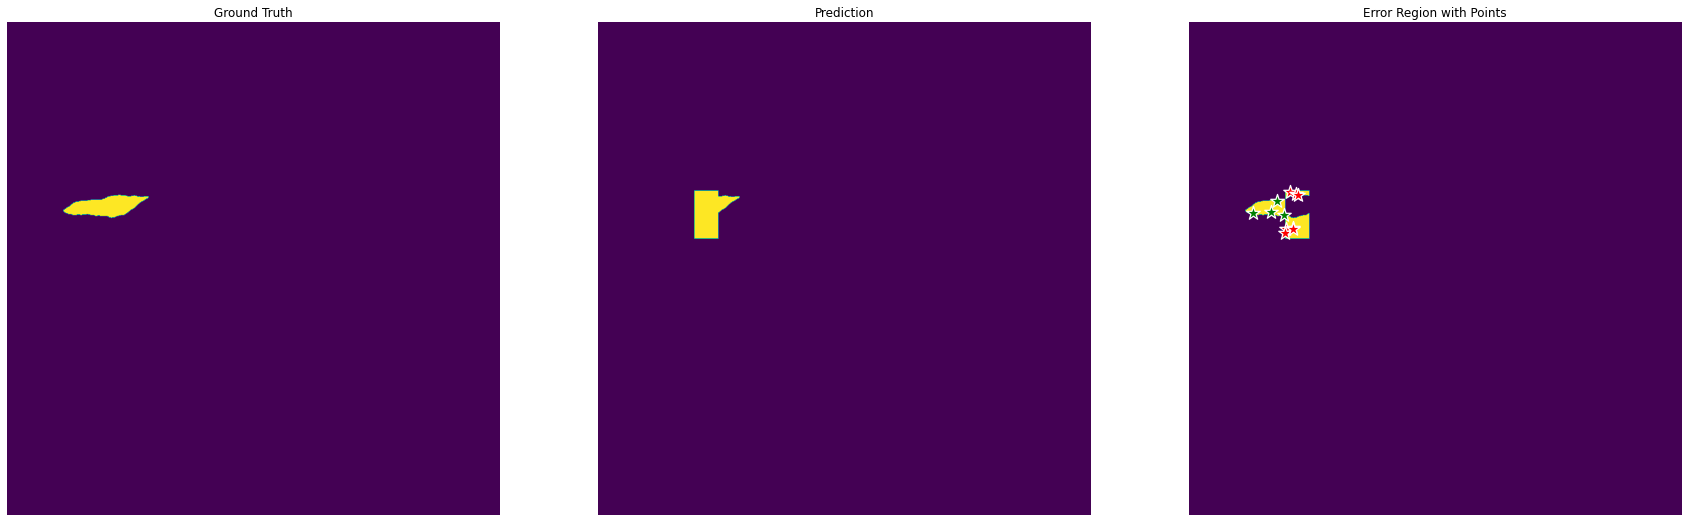

In [86]:
plt.figure(figsize=(30, 30))
plt.subplot(1, 3, 1)
plt.imshow(masks[0, 16])
plt.axis('off'), plt.title('Ground Truth')
plt.subplot(1, 3, 2)
plt.imshow(modified)
plt.axis('off'), plt.title('Prediction')
plt.subplot(1, 3, 3)
plt.imshow(torch.logical_xor(modified, masks[0, 16]))
[show_points(point[0], point[1], plt.gca(), 200) for point in points]
plt.axis('off'), plt.title('Error Region with Points')